In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


In [2]:
raw_df = pd.read_csv(r'/kaggle/input/credit-card-customers/BankChurners.csv')
raw_df = raw_df[raw_df.columns[:-2]]
raw_df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
raw_df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [4]:
#Convert data types of numerical columns to float32
int_col = raw_df.dtypes==int
raw_df.loc[:,int_col[int_col].index.to_list()] = raw_df.loc[:,int_col[int_col].index.to_list()].astype(np.float32)
float_col = raw_df.dtypes==float
raw_df.loc[:,float_col[float_col].index.to_list()] = raw_df.loc[:,float_col[float_col].index.to_list()].astype(np.float32)


In [5]:
#Check null value of each column
raw_df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
dict_cate={'Existing Customer':1, 'Attrited Customer':0}
raw_df['Attrition_Flag'] = raw_df['Attrition_Flag'].apply(lambda x:dict_cate[x])
churned, existed = np.bincount(raw_df['Attrition_Flag'])
print('Existed Customer : {}, Churned Customer : {}'.format(existed, churned))

Existed Customer : 8500, Churned Customer : 1627


In [7]:
train, test = train_test_split(raw_df, test_size = 0.2)
train, val = train_test_split(train, test_size = 0.2)
print('Train number of rows : {}'.format(train.shape[0]))
print('Test number of rows : {}'.format(test.shape[0]))
print('Validation number of rows : {}'.format(val.shape[0]))

Train number of rows : 6480
Test number of rows : 2026
Validation number of rows : 1621


In [8]:
def tf_dataset(df, shuffle=False, batch_size=32):
    label = df.pop('Attrition_Flag')
    df = tf.data.Dataset.from_tensor_slices((dict(df), label))
    if shuffle:
        df = df.shuffle(train.shape[0])
    df = df.batch(batch_size)
    df = df.prefetch(batch_size)
    return df
train = tf_dataset(train, shuffle=True)
test = tf_dataset(test)
val = tf_dataset(val)

In [9]:
def normalization(df, col):
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
    feature = df.map(lambda x, y: x[col])
    normalizer.adapt(feature)
    return normalizer

In [10]:
def category_encoding(df, col):
    index = tf.keras.layers.experimental.preprocessing.StringLookup()
    features = df.map(lambda x, y: x[col])
    index.adapt(features)
    encoder = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=index.vocab_size())
    features = features.map(index)
    encoder.adapt(features)
    return lambda feature: encoder(index(feature))

In [11]:
encoded_features=[]
inputs=[]
float_col = raw_df.dtypes==np.float32
for col in float_col[float_col].index:
    numerical_input = tf.keras.Input(shape=(1,), name=col)
    normalization_layer = normalization(train, col)
    encoded_col = normalization_layer(numerical_input)
    inputs.append(numerical_input)
    encoded_features.append(encoded_col)

In [12]:
category_col = ['Card_Category','Education_Level','Gender','Income_Category','Marital_Status']
for col in category_col:
    categorical_input = tf.keras.Input(shape=(1,), name=col, dtype='string')
    encoding_layer = category_encoding(train, col)
    encoded_col = encoding_layer(categorical_input)
    inputs.append(categorical_input)
    encoded_features.append(encoded_col)
    

In [13]:
inputs

[<tf.Tensor 'CLIENTNUM:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Customer_Age:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Dependent_count:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Months_on_book:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Relationship_Count:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Months_Inactive_12_mon:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Contacts_Count_12_mon:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Credit_Limit:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Revolving_Bal:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Avg_Open_To_Buy:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Amt_Chng_Q4_Q1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Trans_Amt:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Trans_Ct:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Total_Ct_Chng_Q4_Q1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Avg_Utilization_Ratio:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor '

In [14]:
encoded_features

[<tf.Tensor 'normalization/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_1/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_2/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_3/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_4/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_5/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_6/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_7/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_8/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_9/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_10/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_11/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_12/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_13/truediv:0' shape=(None, 1) dtype=

In [15]:
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation='relu')(features)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

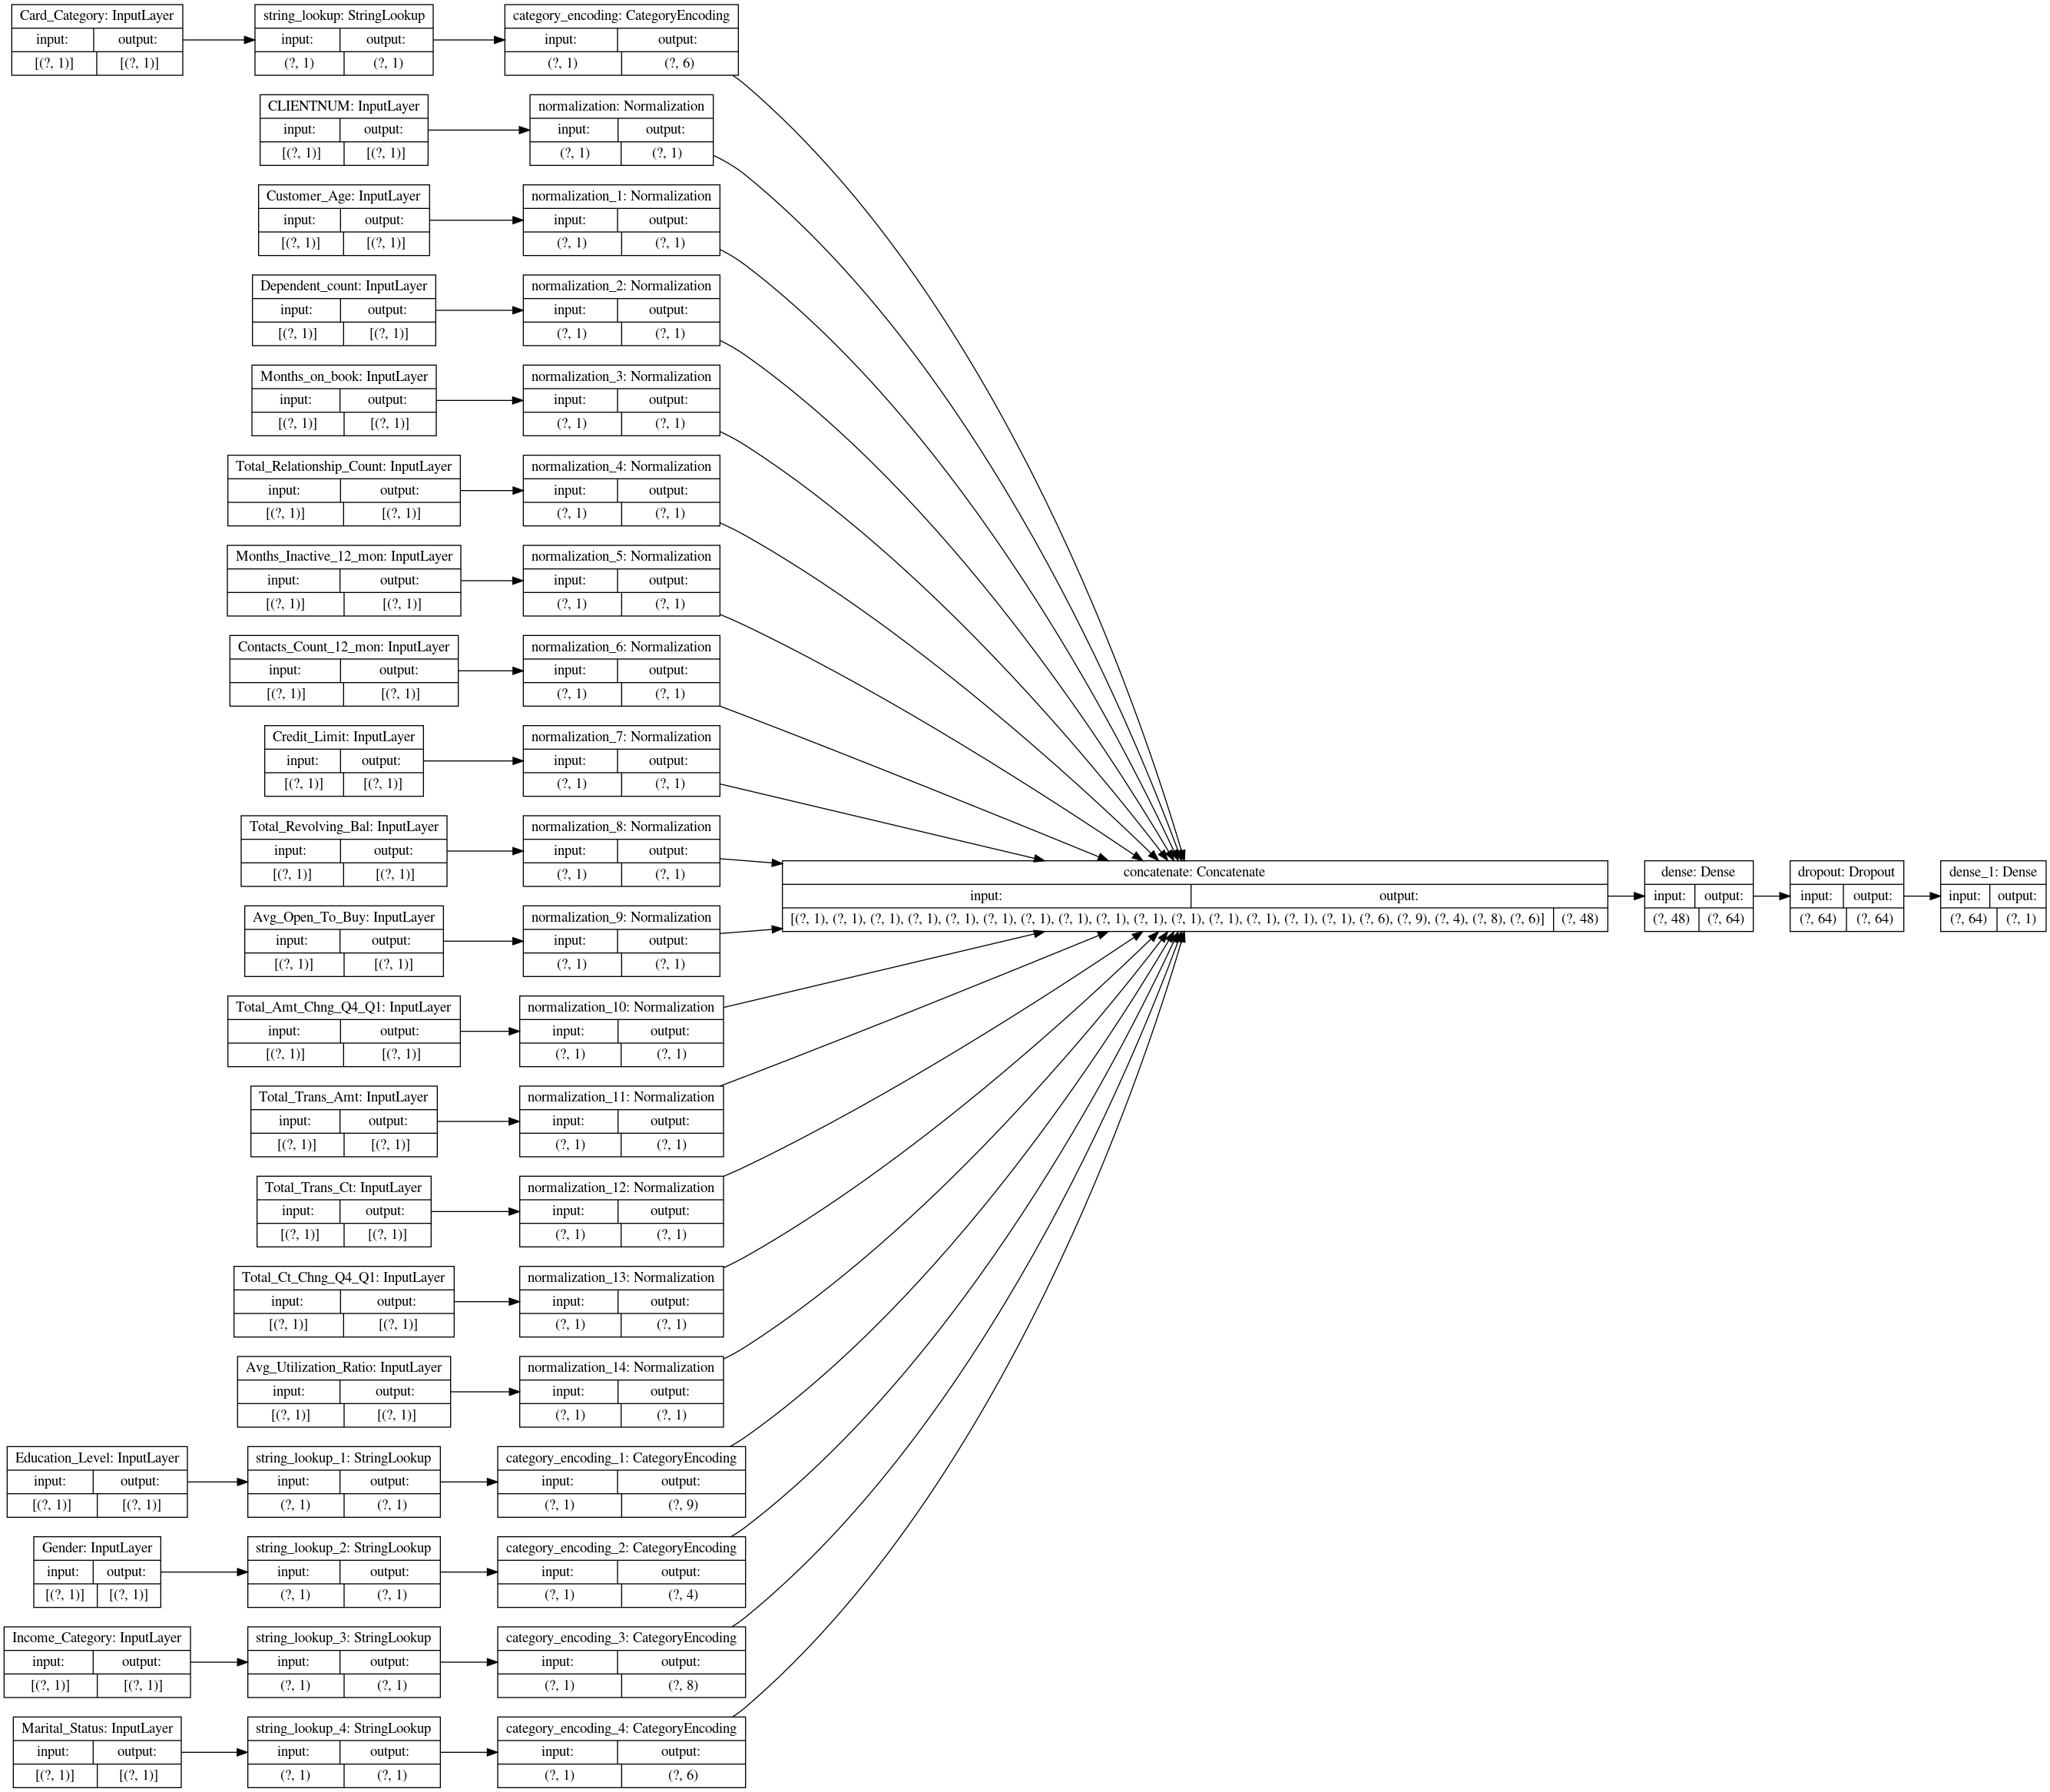

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [17]:
class_weight = {0: 1627/(1627+8500), 1:8500/(1627+8500)}
model.fit(train, validation_data=val, epochs=5, class_weight=class_weight)

Epoch 1/5
203/203 [==============================] - 1s 4ms/step - loss: 0.1373 - accuracy: 0.8083 - val_loss: 0.4082 - val_accuracy: 0.8513
Epoch 2/5
203/203 [==============================] - 1s 3ms/step - loss: 0.0788 - accuracy: 0.8707 - val_loss: 0.3578 - val_accuracy: 0.8816
Epoch 3/5
203/203 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.8823 - val_loss: 0.3275 - val_accuracy: 0.8927
Epoch 4/5
203/203 [==============================] - 1s 3ms/step - loss: 0.0681 - accuracy: 0.8921 - val_loss: 0.2978 - val_accuracy: 0.8982
Epoch 5/5
203/203 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.8969 - val_loss: 0.2949 - val_accuracy: 0.8994
